<div style="background-color: darkslategray; color: white; padding: 15px; border-radius: 8px;">
    <center><h1 style="font-family: Arial, sans-serif;">Predicting Rare Species</h1></center>
    <center><h3 style="font-family: Arial, sans-serif;">Deep Learning Project</h3></center>
</div>

**<h3>Table of Contents</h3>**
* [1. Environment Setup](#1-environment-setup)
    * [1.1 Import Libraries](#11-import-libraries)
    * [1.2 Import Dataset](#12-import-dataset)
* [2. Exploratory Data Analysis](#2-exploratory-data-analysis)
    * [2.1 Visualizations](#21-visualizations)
    * [2.2 Import Dataset](#22-feature-engineering)
* [3. Splitting the Dataset](#3-splitting-the-dataset)
* [4. Splitting the Dataset](#4-preprocessing)
    * [4.1 Image Generator and Augmentation](#41-image-generator-and-augmentation)


<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [3]:
# # # Google Colab
# !pip install keras_cv

In [4]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [6]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [7]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_turdidae/29658536_45510188_eol-full-s...  
4  chordata_indriidae/21252576_7250886_eol-full-s...

In [8]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Exploratory Data Analysis !!!Not Needed

<div>

In [9]:
# kingdom_counts = df['kingdom'].value_counts()
# plot_graph(title='Distribution of Observations Across Kingdom', xlabel='Kingdom', ylabel='Number of Observations',  counts=kingdom_counts)

In [10]:
# phylum_counts = df['phylum'].value_counts()
# plot_graph(title='Distribution of Observations Across Phylum', xlabel='Phylum', ylabel='Number of Observations',  counts=phylum_counts)

In [11]:
# family_counts = df['family'].value_counts()
# plot_graph(title='Distribution of Observations Across Family', xlabel='Family', ylabel='Number of Observations',  counts=family_counts)

In [12]:
# family_counts = df["family"].value_counts(normalize=True)*100

# df_family_proportions = pd.DataFrame({
#     "Family": family_counts.index,
#     "Proportion (%)": family_counts.values  
# })

# df_family_proportions # 202 different families

In [13]:
# num_families_025 = int((df_family_proportions["Proportion (%)"] <= 0.2505).sum())
# num_families_025 # 118 families have less than 0.2505% of images

In [14]:
# top_100_families = df['family'].value_counts().nlargest(100)
# plot_graph(title='Distribution of Observations Across Top 100 Families', xlabel='Family', ylabel='Number of Observations',  counts=top_100_families)

In [15]:
# top_84_family_proportion_sum = df_family_proportions.iloc[:84]["Proportion (%)"].sum()
# top_84_family_proportion_sum # although 118 families represent less than 0.25% of the dataset, the 84 that have >0.25% represent only 70.46% of the dataset

<!-- is it better to predict phylum and then family or a concatenation of the two? -->

In [16]:
# df["phylum_family"] = df["phylum"] + "_" + df["family"]
# df

In [17]:
# family_phylum_counts = df.groupby("phylum")["family"].nunique()

In [18]:
# family_phylum_counts # the phylum with the most families is chordata

In [19]:
# anomaly_counts = df.groupby("family")["phylum"].nunique()

In [20]:
# anomaly_counts.value_counts() # there are no families that belong to more than 1 phylum

In [21]:
# phylum_family_counts = df["phylum_family"].value_counts(normalize=True)*100

# df_phylum_family_proportions = pd.DataFrame({
#     "phylum_family": phylum_family_counts.index,
#     "Proportion (%)": phylum_family_counts.values.round(4)  
# })

# df_phylum_family_proportions # 202 different families

<div class="alert alert-block alert-success">

# **3.** Feature Engineering 

<div>

In [22]:
# Encode family (target) and phylum (metadata feature)
family_encoder = LabelEncoder()
phylum_encoder = LabelEncoder()
df["family_encoded"] = family_encoder.fit_transform(df["family"])
df["phylum_encoded"] = phylum_encoder.fit_transform(df["phylum"])

# Check the number of unique families and phyla
num_families = df["family_encoded"].nunique()
num_phyla = df["phylum_encoded"].nunique()
print(f"Number of unique phyla: {num_phyla}")
print(f"Number of unique families: {num_families}")

# One-hot encode the family and phylum columns
df["phylum_onehot"] = df["phylum_encoded"].apply(lambda x: tf.one_hot(x, depth=num_phyla).numpy())
df["family_onehot"] = df["family_encoded"].apply(lambda x: tf.one_hot(x, depth=num_families).numpy())

# Create a new column for the full file path
# Windows
# df["full_file_path"] = df["file_path"].apply(lambda x: os.path.join(path, x.replace("/", "\\")))
# Mac
df["full_file_path"] = df["file_path"].apply(lambda x: str(Path("../data/rare_species") / x))

# Increase display width
# pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
df.head()

Number of unique phyla: 5
Number of unique families: 202


rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  family_encoded  \
0  mollusca_unionidae/12853737_449393_eol-full-si...             193   
1  chordata_geoemydidae/20969394_793083_eol-full-...              84   
2  chordata_cryptobranchidae/28895411_319982_eol-...              56   
3  chordata_turdidae/29658536_45510188_eol-full-s...             192   
4  chordata_indriidae/21252576_7250886_eol-full-s...             100   

   phylum_encoded              phylum_onehot  \
0               4  [0.0, 0.0, 0.0, 0.0, 1.0]   
1               1  [0.0, 1.0, 0.0, 0.0, 0.0]   
2               1  [0.0, 1.0, 0.0, 0.0, 0.0]   
3               1  [0.0, 1.0, 0.0, 0.0, 0.0]   
4               1  [0.0, 1.0, 0.0, 0.0, 0.0]   

                                       family_onehot  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                      full_file_path  
0  ../data/rare_species/mollusca_unionidae/128537...  
1  ../data/rare_species/chordata_geoemydidae/2096...  
2  ../data/rare_species/chordata_cryptobranchidae...  
3  ../data/rare_species/chordata_turdidae/2965853...  
4  ../data/rare_species/chordata_indriidae/212525...

<div class="alert alert-block alert-success">

# **4.** Splitting the Dataset !!!Not Needed

<div>

In [23]:
# # Split the data into training, validation, and testing sets
train_df, test_valid_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=42, stratify=df['family'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, shuffle=True, random_state=42, stratify=test_valid_df['family'])

In [24]:
# Organize the data into train/val/test directories
image_base_path = Path("../data/rare_species")
base_output_dir = image_base_path

# Copy the images to the new directories
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=train_df, copy=False, split_name="train")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=valid_df, copy=False, split_name="val")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=test_df, copy=False, split_name="test")

# Clean up unnecessary folders
cleanup_folders(image_base_path)

Not found: ../data/rare_species/chordata_ranidae/21985147_2920193_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_bufonidae/14130545_332433_eol-full-size-copy.jpg
Not found: ../data/rare_species/cnidaria_agariciidae/21699220_45276518_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_hexanchidae/29652508_46560148_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_geoemydidae/29538706_793083_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_cervidae/15265090_308403_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_hylobatidae/28175522_1038643_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_mesitornithidae/28312603_915363_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_sparidae/21866390_46580005_eol-full-size-copy.jpg
Not found: ../data/rare_species/arthropoda_formicidae/29369457_460290_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_balaenopteridae/21756543_46559441_eol-

In [25]:
# Update the file paths to point to the new directories
train_df = update_paths(train_df, "train")
valid_df = update_paths(valid_df, "val")
test_df = update_paths(test_df, "test")

In [26]:
# # Export each DataFrame as a .pkl file
# with open("../data/train_df.pkl", "wb") as f:
#     pickle.dump(train_df, f)

# with open("../data/valid_df.pkl", "wb") as f:
#     pickle.dump(valid_df, f)

# with open("../data/test_df.pkl", "wb") as f:
#     pickle.dump(test_df, f)

In [27]:
# sampling train
train_df_sampled, _ = train_test_split(train_df, test_size=0.5, shuffle=True, random_state=42, stratify=train_df['family'])
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=train_df_sampled, copy=True, split_name="train_sampled")
train_df_sampled = update_paths(train_df_sampled, "train_sampled")

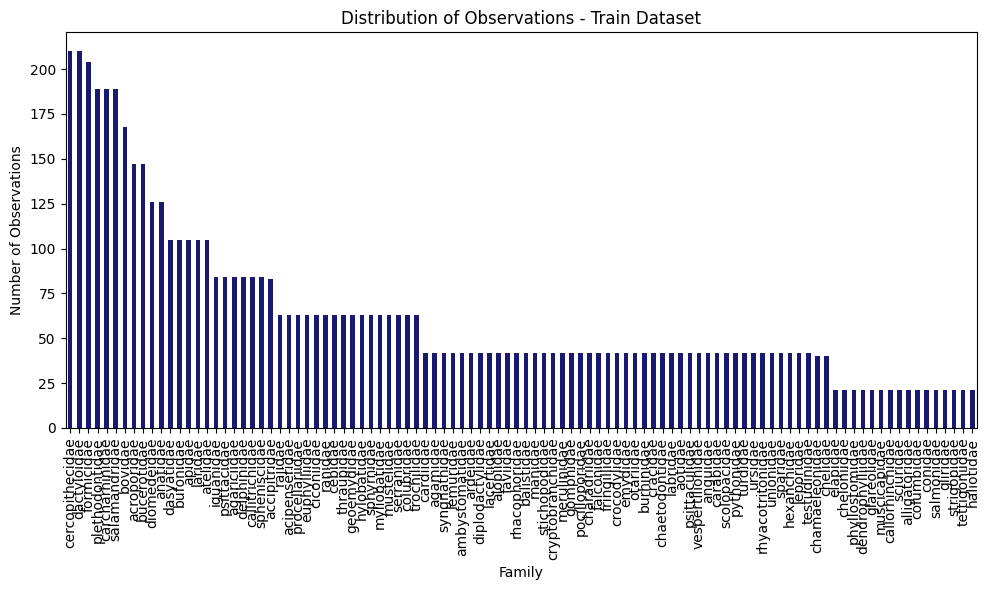

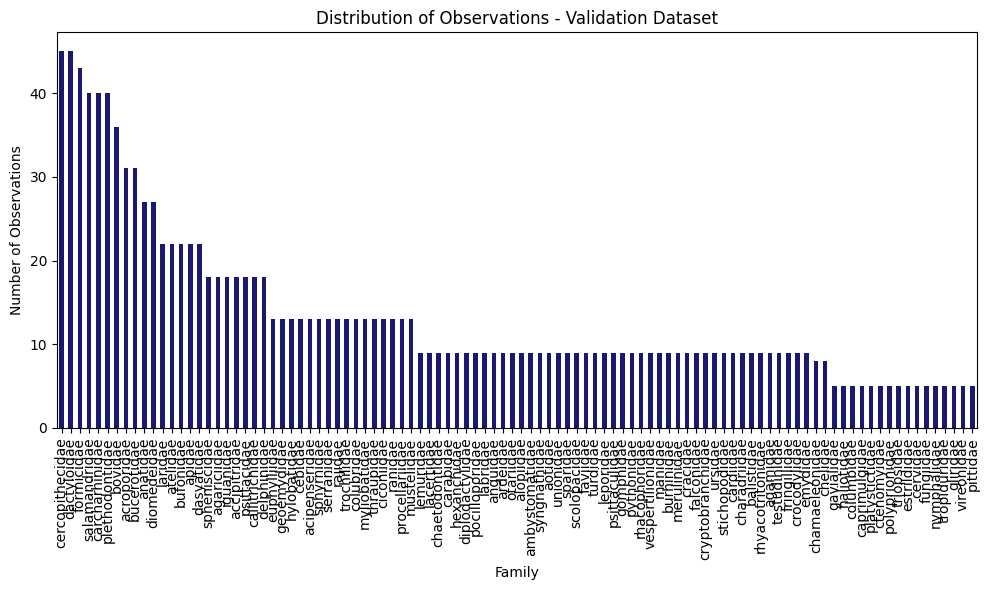

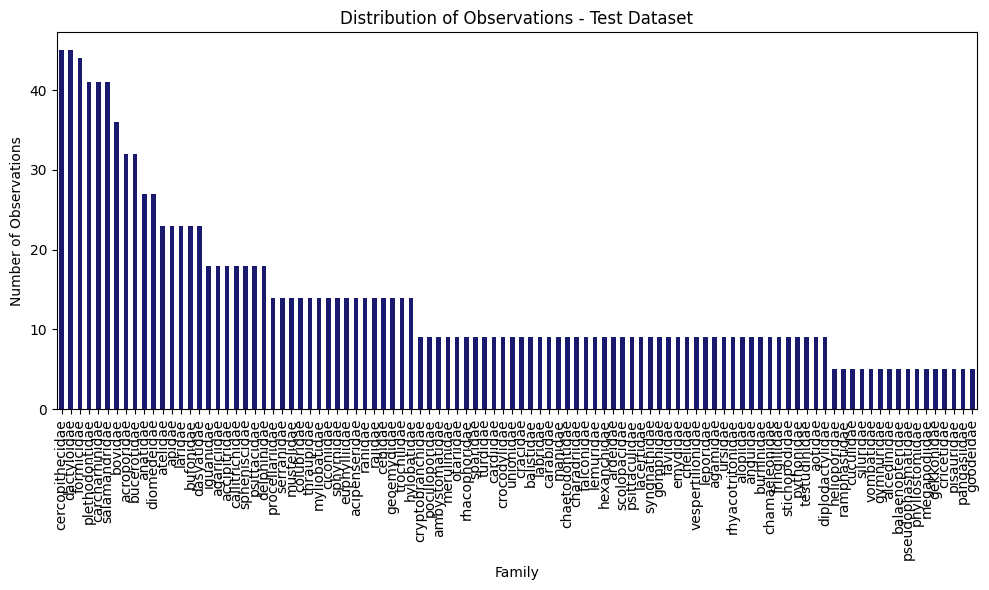

In [28]:
train_df_counts = train_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Train Dataset', xlabel='Family', ylabel='Number of Observations',  counts=train_df_counts )

valid_df_counts = valid_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Validation Dataset', xlabel='Family', ylabel='Number of Observations',  counts=valid_df_counts )

test_df_counts = test_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Test Dataset', xlabel='Family', ylabel='Number of Observations',  counts=test_df_counts )

In [29]:
print(f"Training samples: {len(train_df)}")
print(f"Training sampled samples: {len(train_df_sampled)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 8388
Training sampled samples: 4194
Validation samples: 1797
Testing samples: 1798


<div class="alert alert-block alert-success">

# **5.** Preprocessing

<div>

- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1]).
- Resizes images to a fixed size (e.g., 224x224 pixels).
- Applies augmentation (only during training).
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time).

In [30]:
# Load the DataFrames from the .pkl files
# with open("../data/train_df.pkl", "rb") as f:
#     train_df = pickle.load(f)

# with open("../data/valid_df.pkl", "rb") as f:
#     valid_df = pickle.load(f)

# with open("../data/test_df.pkl", "rb") as f:
#     test_df = pickle.load(f)

In [30]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [31]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

train_ds, class_names = preprocess.load_img(data_dir="../data/rare_species/train", minority_class=minority_class, augment='grayscale', oversampling=True)
train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment='grayscale', oversampling=True)
val_ds, _ = preprocess.load_img(data_dir="../data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
test_ds, _ = preprocess.load_img(data_dir="../data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

Found 8388 files belonging to 202 classes.
Found 4194 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


2025-04-14 17:32:10.228026: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


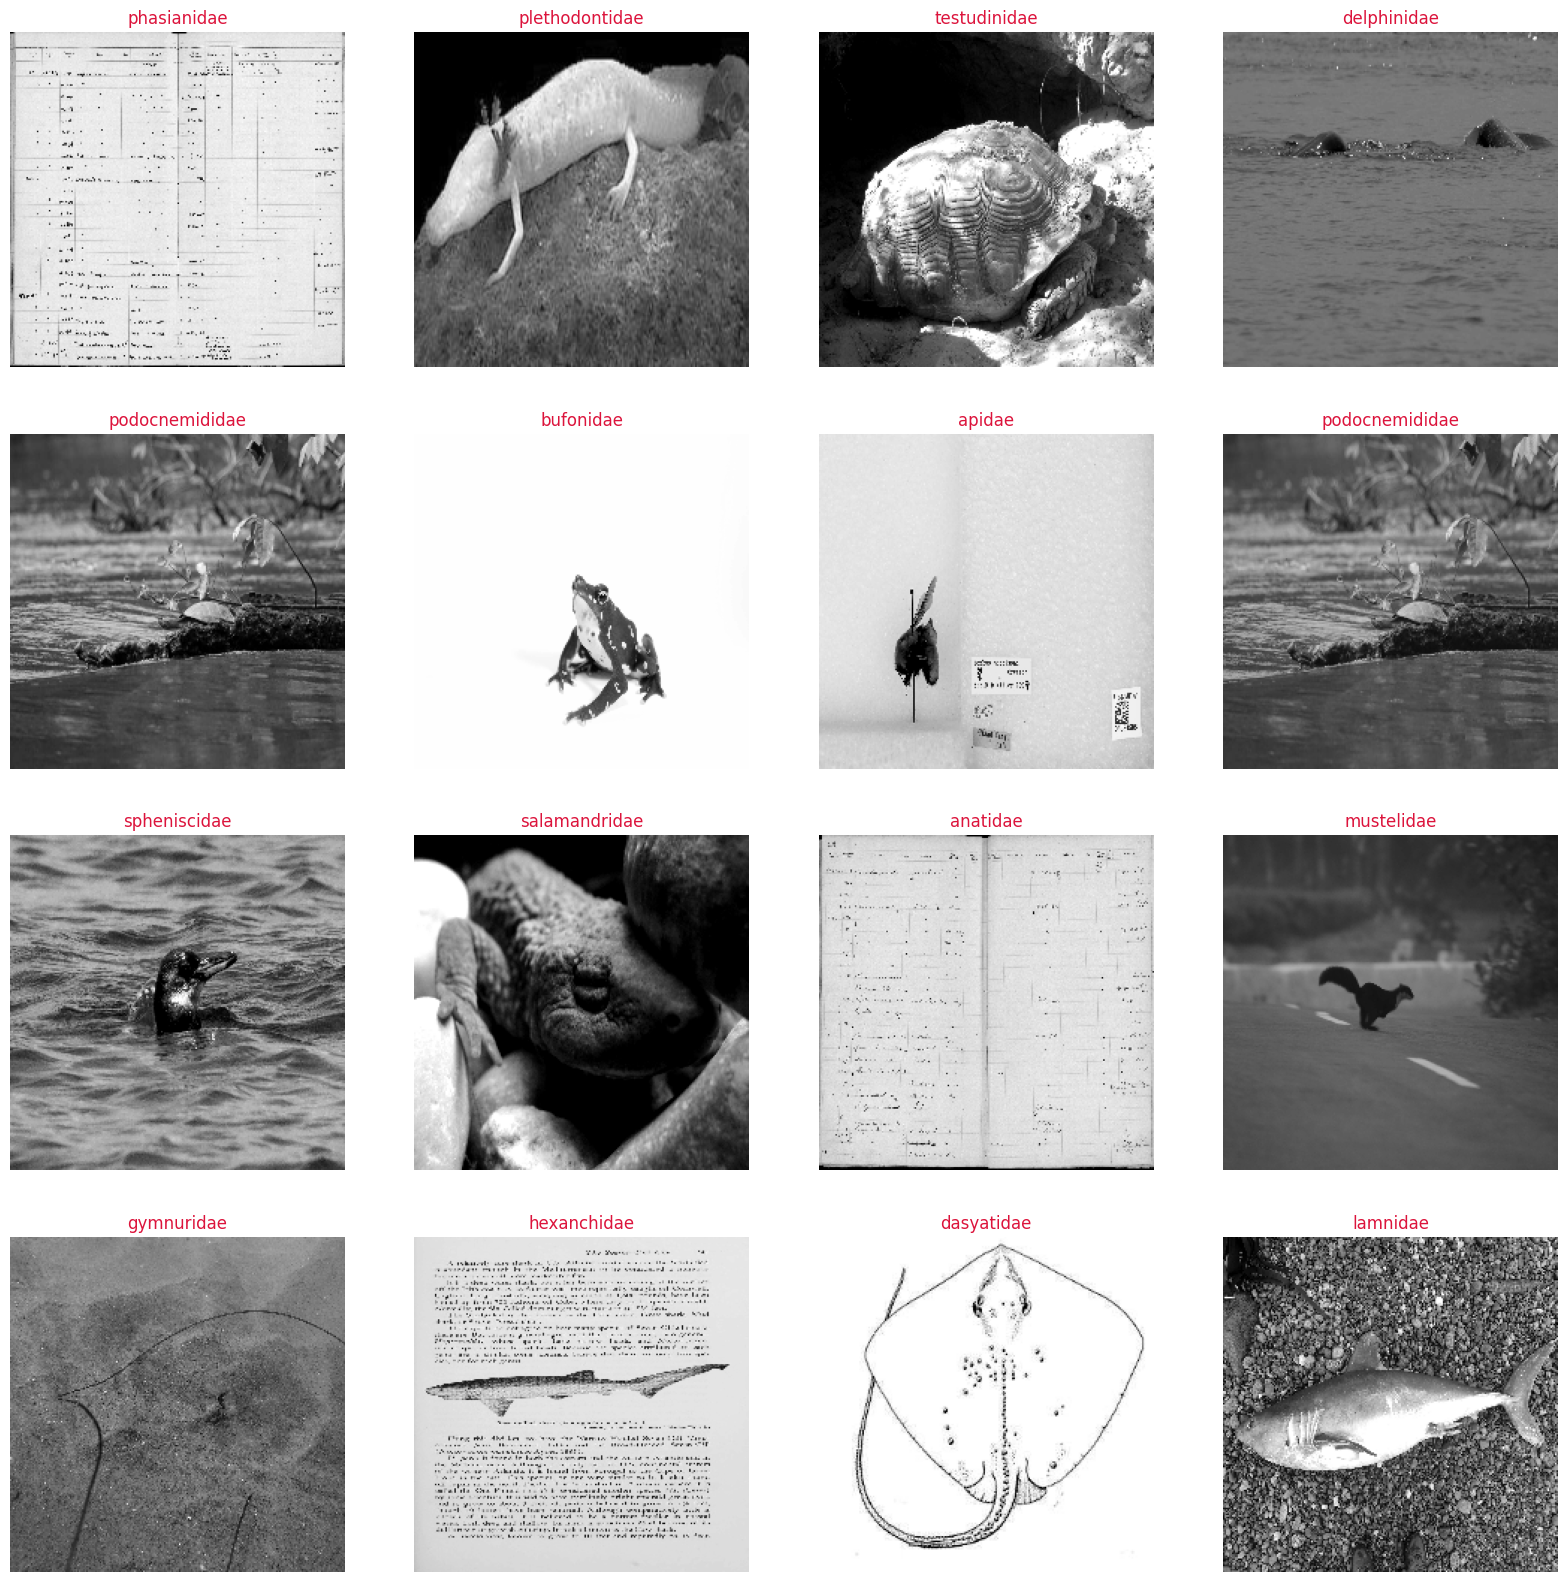

In [32]:
num_images = 16 ##
rows, cols = 4, 4 ##

plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

### With Phylum

In [ ]:
# Create the datasets for training, validation, and testing with both image and phylum as inputs
train_ds = build_ds_with_phylum(train_df)
val_ds = build_ds_with_phylum(valid_df)
test_ds = build_ds_with_phylum(test_df)

train_ds

<_PrefetchDataset element_spec=({'image_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'phylum_input': TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 202), dtype=tf.float32, name=None))>

## 5.1 Outliers

In [14]:
# import os
# from glob import glob

# train_dir = Path("../data/rare_species/train")

# image_paths = glob(os.path.join(train_dir, "*", "*.jpg"))  # ou .png dependendo do teu caso

# print(f"Total de imagens encontradas: {len(image_paths)}")

In [15]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.preprocessing import image
# from sklearn.cluster import DBSCAN
# import numpy as np
# import cv2

# # Modelo ResNet50 para extrair embeddings
# model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# def extract_embedding(img_path):
#     try:
#         img = image.load_img(img_path, target_size=(224, 224))
#         x = image.img_to_array(img)
#         x = preprocess_input(np.expand_dims(x, axis=0))
#         return model.predict(x, verbose=0)[0]
#     except Exception as e:
#         print(f"Erro com {img_path}: {e}")
#         return None

# # Extrair os embeddings
# embeddings = []
# valid_paths = []

# for path in image_paths:
#     emb = extract_embedding(path)
#     if emb is not None:
#         embeddings.append(emb)
#         valid_paths.append(path)

# embeddings = np.array(embeddings)


In [16]:
# len(embeddings)

In [17]:
# from sklearn.metrics.pairwise import pairwise_distances
# import matplotlib.pyplot as plt
# import numpy as np

# # Calcula a matriz de distâncias entre embeddings
# dists = pairwise_distances(embeddings)

# # Para cada ponto, encontra a distância ao seu 5º vizinho mais próximo
# sorted_dists = np.sort(dists, axis=1)
# k_distances = sorted_dists[:, 10]  # min_samples = 5

# # Plot
# plt.figure(figsize=(10, 5))
# plt.plot(np.sort(k_distances))
# plt.title("K-distance plot (5º vizinho)")
# plt.xlabel("Ponto")
# plt.ylabel("Distância ao 5º vizinho")
# plt.grid(True)
# plt.show()


In [18]:
# from sklearn.cluster import DBSCAN
# import numpy as np

# # DBSCAN: ajusta eps conforme o teu dataset
# clustering = DBSCAN(eps=45, min_samples=10).fit(embeddings)
# labels = clustering.labels_

# # -1 indica outliers
# outliers = np.where(labels == -1)[0]
# outlier_paths = [valid_paths[i] for i in outliers]

# print(f"Número de outliers encontrados: {len(outlier_paths)}")

In [19]:
# len(outlier_paths)

In [20]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# def show_images(image_paths, n=20, cols=5, title="Outliers"):
#     plt.figure(figsize=(15, (n // cols + 1) * 3))
#     for i, img_path in enumerate(image_paths[:n]):
#         img = mpimg.imread(img_path)
#         plt.subplot(n // cols + 1, cols, i + 1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(os.path.basename(img_path), fontsize=8)
#     plt.suptitle(title, fontsize=16)
#     plt.tight_layout()
#     plt.show()

# show_images(outlier_paths, n=100, cols=6)


## 5.2 Augmentations

In [21]:
# augmentations_to_test = [
#     # "none",
#     # "light",
#     # "medium",
#     # "heavy",
#     # "grayscale",
#     # "randaugment",
#     "mixup",
#     "cutmix"]

<!-- ##### Simple model do test augmentations -->

In [22]:
# def build_model(num_classes):
#     base = keras.applications.EfficientNetB0(
#         input_shape=(224, 224, 3),
#         include_top=False,
#         weights="imagenet",
#         pooling="avg"
#     )
#     base.trainable = False  # You can fine-tune later

#     inputs = keras.Input(shape=(224, 224, 3))
#     x = base(inputs, training=False)
#     x = keras.layers.Dropout(0.2)(x)
#     outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

#     return keras.Model(inputs, outputs)

In [23]:
# def sample_dataset(dataset, fraction=None, num_batches=None, seed=42):
#     """Return a sampled subset of the dataset."""
#     if fraction:
#         dataset = dataset.shuffle(1000, seed=seed)
#         dataset = dataset.take(int(fraction * tf.data.experimental.cardinality(dataset).numpy()))
#     elif num_batches:
#         dataset = dataset.take(num_batches)
#     return dataset

<!-- ##### Loop -->

In [24]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=5,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


In [25]:
# augmentations_to_test = [
#     "none",
#     "light",
#     "medium",
#     "heavy",
#     "grayscale",
#     "randaugment",
#     "mixup",
#     "cutmix"]

In [26]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=15,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


## 5.3 Class Imbalance

<div class="alert alert-block alert-success">

# **6.** Models

<div>

## With Phylum (Marco)

In [ ]:
# Image input
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=image_input)
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Phylum input
phylum_input = Input(shape=(5,), name="phylum_input")

# Combine both
combined = Concatenate()([x, phylum_input])
combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.3)(combined)
output = Dense(202, activation='softmax')(combined)

model = Model(inputs=[image_input, phylum_input], outputs=output)

# Define the metrics
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)


TopKCategoricalAccuracy(k=5): https://www.tensorflow.org/api_docs/python/tf/keras/metrics/TopKCategoricalAccuracy

This is a more forgiving metric. It considers a prediction correct if the true label is among the model’s top 5 predictions (sorted by probability).
Useful when there are many classes (like 202 families) — even if top-1 is hard, top-5 can still show useful trends

In [47]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_phylum",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Add callbacks
# callbacks = [

# ]

# Run the experiment
history = experiment.run_experiment(callbacks=None, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

Epoch 1/10


2025-04-11 18:08:14.557069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 15/263 ━━━━━━━━━━━━━━━━━━━━ 20:43 5s/step - accuracy: 0.0264 - auc: 0.5590 - f1_macro: 0.0051 - f1_weighted: 0.0230 - loss: 6.2938 - top5_accuracy: 0.0745

/Users/mgalao/Library/CloudStorage/OneDrive-NOVAIMS/MSc_DSAA-DS/2nd Semester/Q3 Deep Learning/deep-learning-project/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-11 18:10:44.974582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 931 of 1000
2025-04-11 18:10:45.690705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-11 18:11:35.622810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 948 of 1000
2025-04-11 18:11:35.859276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle b

263/263 ━━━━━━━━━━━━━━━━━━━━ 199s 697ms/step


2025-04-11 18:16:36.456787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 634ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.0273 - auc: 0.5802 - f1_macro: 0.0069 - f1_weighted: 0.0211 - loss: 6.3229 - top5_accuracy: 0.0871 - val_accuracy: 0.0039 - val_auc: 0.4994 - val_f1_macro: 4.8877e-05 - val_f1_weighted: 7.1424e-05 - val_loss: 11849.8818 - val_top5_accuracy: 1.0000
Epoch 2/10


/Users/mgalao/Library/CloudStorage/OneDrive-NOVAIMS/MSc_DSAA-DS/2nd Semester/Q3 Deep Learning/deep-learning-project/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-11 18:18:14.822112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 850 of 1000
2025-04-11 18:18:17.295121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-11 18:20:31.824892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-11 18:20:41.973407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filli

263/263 ━━━━━━━━━━━━━━━━━━━━ 245s 857ms/step


2025-04-11 18:24:47.479978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 414 of 1000
2025-04-11 18:24:57.501676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 850 of 1000
2025-04-11 18:25:01.124725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-11 18:25:23.174843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-11 18:25:33.754558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 469 of 1000
2025-04-11 18:25:38.924254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 616ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - accuracy: 0.0312 - auc: 0.5596 - f1_macro: 0.0033 - f1_weighted: 0.0208 - loss: 6.5785 - top5_accuracy: 0.0938 - val_accuracy: 0.0223 - val_auc: 0.5087 - val_f1_macro: 2.1820e-04 - val_f1_weighted: 9.8113e-04 - val_loss: 20437.7871 - val_top5_accuracy: 1.0000
Epoch 3/10


/Users/mgalao/Library/CloudStorage/OneDrive-NOVAIMS/MSc_DSAA-DS/2nd Semester/Q3 Deep Learning/deep-learning-project/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-11 18:27:05.487348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 817 of 1000
2025-04-11 18:27:07.516212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-11 18:27:57.292293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 811 of 1000
2025-04-11 18:27:58.758246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle b

263/263 ━━━━━━━━━━━━━━━━━━━━ 242s 862ms/step


2025-04-11 18:33:43.479984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 824 of 1000
2025-04-11 18:33:45.873378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-11 18:33:55.915965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-11 18:34:06.016442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 891 of 1000
2025-04-11 18:34:07.042132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 771ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.0312 - auc: 0.5970 - f1_macro: 0.0050 - f1_weighted: 0.0312 - loss: 6.6790 - top5_accuracy: 0.1250 - val_accuracy: 0.0223 - val_auc: 0.5087 - val_f1_macro: 2.1559e-04 - val_f1_weighted: 9.6938e-04 - val_loss: 36720.8359 - val_top5_accuracy: 1.0000
Epoch 4/10


2025-04-11 18:35:08.201241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 897 of 1000
2025-04-11 18:35:09.220556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  1/263 ━━━━━━━━━━━━━━━━━━━━ 2:56:26 40s/step - accuracy: 0.0312 - auc: 0.5583 - f1_macro: 0.0025 - f1_weighted: 0.0156 - loss: 5.9127 - top5_accuracy: 0.0938

/Users/mgalao/Library/CloudStorage/OneDrive-NOVAIMS/MSc_DSAA-DS/2nd Semester/Q3 Deep Learning/deep-learning-project/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-11 18:36:07.484322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 987 of 1000
2025-04-11 18:36:07.521337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-11 18:36:58.050204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 801 of 1000
2025-04-11 18:37:00.993792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle b

263/263 ━━━━━━━━━━━━━━━━━━━━ 233s 834ms/step


2025-04-11 18:42:45.337268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 746ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.0312 - auc: 0.5743 - f1_macro: 0.0032 - f1_weighted: 0.0198 - loss: 6.5073 - top5_accuracy: 0.0626 - val_accuracy: 0.0223 - val_auc: 0.5087 - val_f1_macro: 2.1559e-04 - val_f1_weighted: 9.6938e-04 - val_loss: 80639.1094 - val_top5_accuracy: 1.0000


## Sequential

In [ ]:
layers = [Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
          MaxPooling2D((2, 2)),
          Conv2D(32, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
          Dense(202, activation="softmax")
          ]

/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
first_sequential_model = build_sequential_model(list_of_layers=layers)
first_sequential_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,278,890 (84.99 MB)

 Trainable params: 22,278,890 (84.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
n_epochs = 1 ##
batch_size = 32 ##
initial_lr = 0.01 ##
final_lr = 0.001 ##

verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [ ]:
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run1.csv",
    lr_scheduler=my_scheduler_fn
)

In [ ]:

first_sequential_model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', metrics= metrics)
history = first_sequential_model.fit(train_ds, epochs= n_epochs, verbose= 1, batch_size = batch_size, validation_data= val_ds, callbacks=callbacks)

NameError: name 'first_sequential_model' is not defined

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=n_epochs, train_acc=acc_train, val_acc=acc_val)

TypeError: plot_model_acc() got an unexpected keyword argument 'train_acc'

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_loss(num_epochs=n_epochs, train_loss=loss_train, val_loss=loss_val)

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## Non Sequential

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D


In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-3  
final_lr = 1e-4
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Junta ao teu callbacks list
callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
    lr_scheduler=my_scheduler_fn
) + [early_stopping]

NameError: name 'CategoricalAccuracy' is not defined

In [ ]:
input_img = Input(shape=(224, 224, 3))

x = Conv2D(16, (3, 3), activation="relu", padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation="relu", padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation="relu", padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(202, activation='softmax')(x)

model = models.Model(inputs=input_img, outputs=output)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3), loss='categorical_crossentropy', metrics=metrics)
history = model.fit(train_ds, epochs=20, batch_size=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - acc: 0.0175 - auc: 0.5417 - f1_score: 0.0060 - loss: 5.2393 - val_acc: 0.0351 - val_auc: 0.6813 - val_f1_score: 0.0019 - val_loss: 5.0261 - learning_rate: 9.5499e-04
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - acc: 0.0580 - auc: 0.6765 - f1_score: 0.0072 - loss: 4.9705 - val_acc: 0.0445 - val_auc: 0.6802 - val_f1_score: 0.0023 - val_loss: 4.9714 - learning_rate: 9.1201e-04
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - acc: 0.0602 - auc: 0.6932 - f1_score: 0.0073 - loss: 4.9081 - val_acc: 0.0651 - val_auc: 0.6974 - val_f1_score: 0.0054 - val_loss: 4.8755 - learning_rate: 8.7096e-04
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 58s 221ms/step - acc: 0.0608 - auc: 0.6952 - f1_score: 0.0070 - loss: 4.9188 - val_acc: 0.0612 - val_auc: 0.6857 - val_f1_score: 0.0050 - val_loss: 4.9346 - learning_rate: 8.3176e-04
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - acc: 0.0620 - auc: 0.6986 - f1_score: 0.0072 - loss

## ResNet50 - Margarida

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
  lr_scheduler=my_scheduler_fn
)

In [ ]:
input_img = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(202, activation='softmax')(x)

# Define final model
model = models.Model(inputs=input_img, outputs=output)

In [ ]:
base_model.trainable = False
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=metrics)
history = model.fit(train_ds, epochs=100, batch_size=16, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100


2025-04-09 14:06:15.141963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


263/263 ━━━━━━━━━━━━━━━━━━━━ 95s 344ms/step - acc: 0.0122 - auc: 0.5367 - f1_score: 0.0056 - loss: 5.4601 - val_acc: 0.0406 - val_auc: 0.6022 - val_f1_score: 0.0038 - val_loss: 5.1990 - learning_rate: 9.5499e-05
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 104s 394ms/step - acc: 0.0426 - auc: 0.6097 - f1_score: 0.0123 - loss: 5.2302 - val_acc: 0.0723 - val_auc: 0.6638 - val_f1_score: 0.0134 - val_loss: 5.0280 - learning_rate: 9.1201e-05
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 127s 483ms/step - acc: 0.0609 - auc: 0.6411 - f1_score: 0.0146 - loss: 5.1296 - val_acc: 0.0829 - val_auc: 0.6912 - val_f1_score: 0.0181 - val_loss: 4.9113 - learning_rate: 8.7096e-05
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 127s 483ms/step - acc: 0.0650 - auc: 0.6587 - f1_score: 0.0144 - loss: 5.0628 - val_acc: 0.0890 - val_auc: 0.7080 - val_f1_score: 0.0210 - val_loss: 4.8387 - learning_rate: 8.3176e-05
Epoch 5/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 130s 494ms/step - acc: 0.0735 - auc: 0.6729 - f1_score: 0.0179 - loss: 4

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_acc(num_epochs=5, train_loss=loss_train, train_val=loss_val)

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
xaxis = range(1,epochs+1)
plt.plot(xaxis, loss_train, 'g', label='Training loss')
plt.plot(xaxis, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## ResNet50 - Margarida - com preprocessing

### Original

In [17]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [18]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=minority_class,
    augment='mixup',
    oversampling=True,
    preprocessing_function=preprocess_input
)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=minority_class,
    augment=None,
    preprocessing_function=preprocess_input
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [21]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


In [20]:
input_img = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=metrics
)


In [16]:
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_pre_finetuning",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,           # Reduce LR if no improvement after 2 epochs
        min_lr=1e-6,
        verbose=1
    )]
    
# Run the experiment
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=100) # callbacks=None use default callbacks (created in the Experiment class)

No checkpoint found, starting from scratch.
Epoch 1/100


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-04-12 22:36:03.801260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.0102 - auc: 0.5213 - f1_score: 0.0061 - loss: 6.8408

2025-04-12 22:38:31.452462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(43, 224, 224, 3))
  warnings.warn(msg)


263/263 ━━━━━━━━━━━━━━━━━━━━ 130s 486ms/step


2025-04-12 22:40:42.058662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.0102 - auc: 0.5213 - f1_score: 0.0061 - loss: 6.8407 - val_accuracy: 0.1241 - val_auc: 0.7289 - val_f1_score: 0.0280 - val_loss: 4.7248 - learning_rate: 1.0000e-04
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.0396 - auc: 0.5666 - f1_score: 0.0182 - loss: 6.4499

2025-04-12 22:43:30.846022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 445ms/step


2025-04-12 22:45:28.748213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 309ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.0396 - auc: 0.5666 - f1_score: 0.0182 - loss: 6.4493 - val_accuracy: 0.2126 - val_auc: 0.8024 - val_f1_score: 0.0791 - val_loss: 4.1113 - learning_rate: 1.0000e-04
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0794 - auc: 0.6006 - f1_score: 0.0381 - loss: 5.6843

2025-04-12 23:11:12.982821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 158s 592ms/step


2025-04-12 23:13:51.549775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 304ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1702s 6s/step - accuracy: 0.0794 - auc: 0.6006 - f1_score: 0.0381 - loss: 5.6836 - val_accuracy: 0.2732 - val_auc: 0.8567 - val_f1_score: 0.1308 - val_loss: 3.6592 - learning_rate: 1.0000e-04
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.1210 - auc: 0.6372 - f1_score: 0.0722 - loss: 5.0067

2025-04-12 23:16:50.394127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 468ms/step


2025-04-12 23:18:54.587989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.1211 - auc: 0.6372 - f1_score: 0.0722 - loss: 5.0063 - val_accuracy: 0.3261 - val_auc: 0.8931 - val_f1_score: 0.1931 - val_loss: 3.2896 - learning_rate: 1.0000e-04
Epoch 5/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.1723 - auc: 0.6627 - f1_score: 0.1146 - loss: 4.5021

2025-04-12 23:21:51.802883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 172s 653ms/step


2025-04-12 23:24:44.494343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 307ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.1723 - auc: 0.6627 - f1_score: 0.1147 - loss: 4.5017 - val_accuracy: 0.3762 - val_auc: 0.9147 - val_f1_score: 0.2506 - val_loss: 3.0241 - learning_rate: 1.0000e-04
Epoch 6/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2215 - auc: 0.6818 - f1_score: 0.1585 - loss: 4.1302

2025-04-12 23:54:04.040916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step


2025-04-13 00:04:10.752806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 307ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 2337s 9s/step - accuracy: 0.2216 - auc: 0.6818 - f1_score: 0.1586 - loss: 4.1299 - val_accuracy: 0.4035 - val_auc: 0.9297 - val_f1_score: 0.2872 - val_loss: 2.7939 - learning_rate: 1.0000e-04
Epoch 7/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2625 - auc: 0.7021 - f1_score: 0.1948 - loss: 3.8037

2025-04-13 00:34:09.484411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 635s 2s/step


2025-04-13 00:44:45.559037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 2436s 9s/step - accuracy: 0.2626 - auc: 0.7021 - f1_score: 0.1949 - loss: 3.8034 - val_accuracy: 0.4385 - val_auc: 0.9375 - val_f1_score: 0.3319 - val_loss: 2.6411 - learning_rate: 1.0000e-04
Epoch 8/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.3051 - auc: 0.7115 - f1_score: 0.2388 - loss: 3.5686

2025-04-13 00:47:47.985534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 448ms/step


2025-04-13 00:49:46.982560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.3052 - auc: 0.7115 - f1_score: 0.2389 - loss: 3.5684 - val_accuracy: 0.4580 - val_auc: 0.9452 - val_f1_score: 0.3561 - val_loss: 2.5056 - learning_rate: 1.0000e-04
Epoch 9/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.3390 - auc: 0.7226 - f1_score: 0.2726 - loss: 3.3438

2025-04-13 00:52:36.860247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 456ms/step


2025-04-13 00:54:37.809758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.3391 - auc: 0.7226 - f1_score: 0.2727 - loss: 3.3436 - val_accuracy: 0.4786 - val_auc: 0.9498 - val_f1_score: 0.3880 - val_loss: 2.4079 - learning_rate: 1.0000e-04
Epoch 10/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.3745 - auc: 0.7289 - f1_score: 0.3065 - loss: 3.1775

2025-04-13 00:57:35.066865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 449ms/step


2025-04-13 00:59:33.902831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.3745 - auc: 0.7289 - f1_score: 0.3066 - loss: 3.1774 - val_accuracy: 0.4953 - val_auc: 0.9534 - val_f1_score: 0.4108 - val_loss: 2.3200 - learning_rate: 1.0000e-04
Epoch 11/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.3931 - auc: 0.7364 - f1_score: 0.3249 - loss: 3.0614

2025-04-13 01:02:27.415790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 449ms/step


2025-04-13 01:04:26.332641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.3932 - auc: 0.7364 - f1_score: 0.3250 - loss: 3.0612 - val_accuracy: 0.5075 - val_auc: 0.9551 - val_f1_score: 0.4339 - val_loss: 2.2509 - learning_rate: 1.0000e-04
Epoch 12/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.4187 - auc: 0.7383 - f1_score: 0.3502 - loss: 2.9363

2025-04-13 01:07:22.232483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 453ms/step


2025-04-13 01:09:22.140623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.4187 - auc: 0.7383 - f1_score: 0.3503 - loss: 2.9362 - val_accuracy: 0.5203 - val_auc: 0.9568 - val_f1_score: 0.4520 - val_loss: 2.2051 - learning_rate: 1.0000e-04
Epoch 13/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.4433 - auc: 0.7415 - f1_score: 0.3790 - loss: 2.8416

2025-04-13 01:12:20.421792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 451ms/step


2025-04-13 01:14:19.916028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.4433 - auc: 0.7415 - f1_score: 0.3791 - loss: 2.8415 - val_accuracy: 0.5320 - val_auc: 0.9583 - val_f1_score: 0.4650 - val_loss: 2.1460 - learning_rate: 1.0000e-04
Epoch 14/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.4692 - auc: 0.7469 - f1_score: 0.4004 - loss: 2.7301

2025-04-13 01:17:18.518704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 458ms/step


2025-04-13 01:19:19.583632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.4693 - auc: 0.7469 - f1_score: 0.4005 - loss: 2.7300 - val_accuracy: 0.5437 - val_auc: 0.9595 - val_f1_score: 0.4763 - val_loss: 2.1113 - learning_rate: 1.0000e-04
Epoch 15/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4860 - auc: 0.7497 - f1_score: 0.4153 - loss: 2.6563

2025-04-13 01:22:18.963023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 128s 484ms/step


2025-04-13 01:24:27.066985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 325ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.4860 - auc: 0.7497 - f1_score: 0.4154 - loss: 2.6563 - val_accuracy: 0.5481 - val_auc: 0.9598 - val_f1_score: 0.4783 - val_loss: 2.0713 - learning_rate: 1.0000e-04
Epoch 16/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.5038 - auc: 0.7535 - f1_score: 0.4412 - loss: 2.5687

2025-04-13 01:27:26.868656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 450ms/step


2025-04-13 01:29:25.949296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 326ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.5039 - auc: 0.7535 - f1_score: 0.4413 - loss: 2.5686 - val_accuracy: 0.5559 - val_auc: 0.9596 - val_f1_score: 0.4937 - val_loss: 2.0350 - learning_rate: 1.0000e-04
Epoch 17/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5125 - auc: 0.7501 - f1_score: 0.4445 - loss: 2.5324

2025-04-13 01:32:25.929540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 456ms/step


2025-04-13 01:34:26.687995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 323ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.5125 - auc: 0.7501 - f1_score: 0.4446 - loss: 2.5323 - val_accuracy: 0.5687 - val_auc: 0.9621 - val_f1_score: 0.5132 - val_loss: 2.0104 - learning_rate: 1.0000e-04
Epoch 18/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5366 - auc: 0.7566 - f1_score: 0.4717 - loss: 2.4547

2025-04-13 01:37:26.849877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 459ms/step


2025-04-13 01:39:28.248621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.5366 - auc: 0.7566 - f1_score: 0.4718 - loss: 2.4546 - val_accuracy: 0.5693 - val_auc: 0.9610 - val_f1_score: 0.5165 - val_loss: 1.9854 - learning_rate: 1.0000e-04
Epoch 19/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.5472 - auc: 0.7576 - f1_score: 0.4781 - loss: 2.3957

2025-04-13 01:42:32.503137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 469ms/step


2025-04-13 01:44:36.721537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.5472 - auc: 0.7576 - f1_score: 0.4782 - loss: 2.3956 - val_accuracy: 0.5737 - val_auc: 0.9620 - val_f1_score: 0.5232 - val_loss: 1.9615 - learning_rate: 1.0000e-04
Epoch 20/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.5563 - auc: 0.7601 - f1_score: 0.4898 - loss: 2.3448

2025-04-13 01:47:37.873955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step


2025-04-13 01:55:55.157146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 312ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 678s 3s/step - accuracy: 0.5563 - auc: 0.7601 - f1_score: 0.4899 - loss: 2.3447 - val_accuracy: 0.5776 - val_auc: 0.9636 - val_f1_score: 0.5304 - val_loss: 1.9474 - learning_rate: 1.0000e-04
Epoch 21/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5662 - auc: 0.7622 - f1_score: 0.4941 - loss: 2.3128

2025-04-13 02:14:50.796874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 134s 506ms/step


2025-04-13 02:17:05.431552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1272s 5s/step - accuracy: 0.5662 - auc: 0.7622 - f1_score: 0.4943 - loss: 2.3128 - val_accuracy: 0.5860 - val_auc: 0.9632 - val_f1_score: 0.5396 - val_loss: 1.9299 - learning_rate: 1.0000e-04
Epoch 22/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5768 - auc: 0.7640 - f1_score: 0.5089 - loss: 2.2499

2025-04-13 02:20:28.437808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 123s 466ms/step


2025-04-13 02:22:32.216680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.5768 - auc: 0.7640 - f1_score: 0.5090 - loss: 2.2499 - val_accuracy: 0.5860 - val_auc: 0.9615 - val_f1_score: 0.5398 - val_loss: 1.9200 - learning_rate: 1.0000e-04
Epoch 23/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5848 - auc: 0.7629 - f1_score: 0.5162 - loss: 2.2363

2025-04-13 02:34:12.493769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step


2025-04-13 02:45:41.141888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 312ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1388s 5s/step - accuracy: 0.5848 - auc: 0.7629 - f1_score: 0.5163 - loss: 2.2362 - val_accuracy: 0.5938 - val_auc: 0.9634 - val_f1_score: 0.5496 - val_loss: 1.9025 - learning_rate: 1.0000e-04
Epoch 24/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.5933 - auc: 0.7658 - f1_score: 0.5285 - loss: 2.1729

2025-04-13 02:49:27.489781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1048s 4s/step


2025-04-13 03:06:56.018018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1275s 5s/step - accuracy: 0.5933 - auc: 0.7658 - f1_score: 0.5287 - loss: 2.1729 - val_accuracy: 0.6038 - val_auc: 0.9659 - val_f1_score: 0.5651 - val_loss: 1.8903 - learning_rate: 1.0000e-04
Epoch 25/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6072 - auc: 0.7650 - f1_score: 0.5400 - loss: 2.1412

2025-04-13 03:15:42.454429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 912s 3s/step


2025-04-13 03:30:54.549160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 914ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1472s 6s/step - accuracy: 0.6073 - auc: 0.7650 - f1_score: 0.5402 - loss: 2.1411 - val_accuracy: 0.6038 - val_auc: 0.9635 - val_f1_score: 0.5593 - val_loss: 1.8775 - learning_rate: 1.0000e-04
Epoch 26/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.6167 - auc: 0.7672 - f1_score: 0.5486 - loss: 2.1109

2025-04-13 03:34:24.787002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 463ms/step


2025-04-13 03:36:27.480854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.6168 - auc: 0.7672 - f1_score: 0.5488 - loss: 2.1108 - val_accuracy: 0.6099 - val_auc: 0.9638 - val_f1_score: 0.5698 - val_loss: 1.8749 - learning_rate: 1.0000e-04
Epoch 27/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.6165 - auc: 0.7679 - f1_score: 0.5494 - loss: 2.1059

2025-04-13 03:39:36.177532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 464ms/step


2025-04-13 03:41:39.017704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.6165 - auc: 0.7679 - f1_score: 0.5495 - loss: 2.1058 - val_accuracy: 0.6038 - val_auc: 0.9647 - val_f1_score: 0.5646 - val_loss: 1.8651 - learning_rate: 1.0000e-04
Epoch 28/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.6231 - auc: 0.7685 - f1_score: 0.5541 - loss: 2.0721

2025-04-13 03:44:37.844285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 123s 467ms/step


2025-04-13 03:46:41.417254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.6231 - auc: 0.7685 - f1_score: 0.5543 - loss: 2.0720 - val_accuracy: 0.6116 - val_auc: 0.9640 - val_f1_score: 0.5714 - val_loss: 1.8541 - learning_rate: 1.0000e-04
Epoch 29/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.6423 - auc: 0.7705 - f1_score: 0.5748 - loss: 2.0224

2025-04-13 03:49:51.015742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 470ms/step


2025-04-13 03:51:55.611475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.6423 - auc: 0.7705 - f1_score: 0.5749 - loss: 2.0224 - val_accuracy: 0.6110 - val_auc: 0.9636 - val_f1_score: 0.5759 - val_loss: 1.8482 - learning_rate: 1.0000e-04
Epoch 30/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.6496 - auc: 0.7715 - f1_score: 0.5806 - loss: 1.9873

2025-04-13 03:55:00.882513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 463ms/step


2025-04-13 03:57:03.411486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.6497 - auc: 0.7715 - f1_score: 0.5807 - loss: 1.9873 - val_accuracy: 0.6132 - val_auc: 0.9655 - val_f1_score: 0.5805 - val_loss: 1.8391 - learning_rate: 1.0000e-04
Epoch 31/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.6511 - auc: 0.7693 - f1_score: 0.5796 - loss: 1.9877

2025-04-13 04:00:04.111308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 464ms/step


2025-04-13 04:02:06.857552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.6511 - auc: 0.7693 - f1_score: 0.5798 - loss: 1.9876 - val_accuracy: 0.6121 - val_auc: 0.9661 - val_f1_score: 0.5810 - val_loss: 1.8349 - learning_rate: 1.0000e-04
Epoch 32/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6560 - auc: 0.7717 - f1_score: 0.5865 - loss: 1.9665

2025-04-13 04:05:10.233774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 125s 472ms/step


2025-04-13 04:07:15.273459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.6560 - auc: 0.7716 - f1_score: 0.5867 - loss: 1.9665 - val_accuracy: 0.6144 - val_auc: 0.9648 - val_f1_score: 0.5776 - val_loss: 1.8258 - learning_rate: 1.0000e-04
Epoch 33/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.6555 - auc: 0.7739 - f1_score: 0.5857 - loss: 1.9305

2025-04-13 04:10:27.315229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 129s 490ms/step


2025-04-13 04:12:36.892613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.6556 - auc: 0.7739 - f1_score: 0.5859 - loss: 1.9305 - val_accuracy: 0.6166 - val_auc: 0.9649 - val_f1_score: 0.5862 - val_loss: 1.8256 - learning_rate: 1.0000e-04
Epoch 34/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.6725 - auc: 0.7736 - f1_score: 0.6012 - loss: 1.9141

2025-04-13 04:15:46.880329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 126s 479ms/step


2025-04-13 04:17:53.801699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.6725 - auc: 0.7736 - f1_score: 0.6013 - loss: 1.9140 - val_accuracy: 0.6177 - val_auc: 0.9658 - val_f1_score: 0.5865 - val_loss: 1.8166 - learning_rate: 1.0000e-04
Epoch 35/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6791 - auc: 0.7751 - f1_score: 0.6087 - loss: 1.8939

2025-04-13 04:21:01.664257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 127s 480ms/step


2025-04-13 04:23:08.727254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.6792 - auc: 0.7751 - f1_score: 0.6089 - loss: 1.8938 - val_accuracy: 0.6221 - val_auc: 0.9649 - val_f1_score: 0.5906 - val_loss: 1.8107 - learning_rate: 1.0000e-04
Epoch 36/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.6767 - auc: 0.7741 - f1_score: 0.6104 - loss: 1.8744

2025-04-13 04:26:30.829327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 127s 482ms/step


2025-04-13 04:28:38.364461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 338ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.6767 - auc: 0.7741 - f1_score: 0.6105 - loss: 1.8744 - val_accuracy: 0.6155 - val_auc: 0.9642 - val_f1_score: 0.5832 - val_loss: 1.8155 - learning_rate: 1.0000e-04
Epoch 37/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6880 - auc: 0.7756 - f1_score: 0.6168 - loss: 1.8493

2025-04-13 04:31:49.942011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1145s 4s/step


2025-04-13 04:50:55.102113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1337s 5s/step - accuracy: 0.6880 - auc: 0.7756 - f1_score: 0.6169 - loss: 1.8493 - val_accuracy: 0.6227 - val_auc: 0.9662 - val_f1_score: 0.5899 - val_loss: 1.8041 - learning_rate: 1.0000e-04
Epoch 38/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.6929 - auc: 0.7767 - f1_score: 0.6216 - loss: 1.8361

2025-04-13 05:10:09.655501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step


2025-04-13 05:15:36.302530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 314ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1481s 6s/step - accuracy: 0.6930 - auc: 0.7767 - f1_score: 0.6217 - loss: 1.8361 - val_accuracy: 0.6233 - val_auc: 0.9653 - val_f1_score: 0.5863 - val_loss: 1.7991 - learning_rate: 1.0000e-04
Epoch 39/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6922 - auc: 0.7771 - f1_score: 0.6212 - loss: 1.8273

2025-04-13 05:49:13.632793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 2018s 8s/step


2025-04-13 06:22:51.915634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 4966s 19s/step - accuracy: 0.6922 - auc: 0.7771 - f1_score: 0.6214 - loss: 1.8273 - val_accuracy: 0.6249 - val_auc: 0.9656 - val_f1_score: 0.5898 - val_loss: 1.7959 - learning_rate: 1.0000e-04
Epoch 40/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7073 - auc: 0.7772 - f1_score: 0.6320 - loss: 1.7907

2025-04-13 07:12:17.457746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 216s 817ms/step


2025-04-13 07:15:53.526947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 939s 17s/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 3171s 12s/step - accuracy: 0.7073 - auc: 0.7772 - f1_score: 0.6322 - loss: 1.7907 - val_accuracy: 0.6249 - val_auc: 0.9648 - val_f1_score: 0.5866 - val_loss: 1.7911 - learning_rate: 1.0000e-04
Epoch 41/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7027 - auc: 0.7762 - f1_score: 0.6301 - loss: 1.8019

2025-04-13 08:16:24.643359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1122s 4s/step


2025-04-13 08:35:07.271158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 3836s 15s/step - accuracy: 0.7027 - auc: 0.7762 - f1_score: 0.6302 - loss: 1.8019 - val_accuracy: 0.6277 - val_auc: 0.9651 - val_f1_score: 0.5899 - val_loss: 1.7857 - learning_rate: 1.0000e-04
Epoch 42/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7136 - auc: 0.7764 - f1_score: 0.6396 - loss: 1.7843

2025-04-13 08:56:32.332639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 454ms/step


2025-04-13 08:58:32.705389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1401s 5s/step - accuracy: 0.7135 - auc: 0.7764 - f1_score: 0.6397 - loss: 1.7843 - val_accuracy: 0.6272 - val_auc: 0.9647 - val_f1_score: 0.5916 - val_loss: 1.7883 - learning_rate: 1.0000e-04
Epoch 43/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7119 - auc: 0.7787 - f1_score: 0.6393 - loss: 1.7739

2025-04-13 09:01:16.535705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 445ms/step


2025-04-13 09:03:14.310469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.7120 - auc: 0.7787 - f1_score: 0.6394 - loss: 1.7739 - val_accuracy: 0.6216 - val_auc: 0.9652 - val_f1_score: 0.5825 - val_loss: 1.7836 - learning_rate: 1.0000e-04
Epoch 44/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7154 - auc: 0.7785 - f1_score: 0.6447 - loss: 1.7664

2025-04-13 09:06:08.953004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 2047s 8s/step


2025-04-13 09:40:16.960356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 2222s 8s/step - accuracy: 0.7154 - auc: 0.7785 - f1_score: 0.6448 - loss: 1.7663 - val_accuracy: 0.6322 - val_auc: 0.9650 - val_f1_score: 0.5961 - val_loss: 1.7795 - learning_rate: 1.0000e-04
Epoch 45/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7162 - auc: 0.7785 - f1_score: 0.6463 - loss: 1.7571

2025-04-13 10:09:22.388807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 116s 438ms/step


2025-04-13 10:11:18.393278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1860s 7s/step - accuracy: 0.7162 - auc: 0.7785 - f1_score: 0.6465 - loss: 1.7571 - val_accuracy: 0.6260 - val_auc: 0.9651 - val_f1_score: 0.5916 - val_loss: 1.7823 - learning_rate: 1.0000e-04
Epoch 46/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7241 - auc: 0.7787 - f1_score: 0.6515 - loss: 1.7307

2025-04-13 10:14:01.611826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 116s 440ms/step


2025-04-13 10:15:58.285645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.7241 - auc: 0.7787 - f1_score: 0.6516 - loss: 1.7307 - val_accuracy: 0.6338 - val_auc: 0.9638 - val_f1_score: 0.5966 - val_loss: 1.7764 - learning_rate: 1.0000e-04
Epoch 47/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7254 - auc: 0.7814 - f1_score: 0.6566 - loss: 1.7184

2025-04-13 10:18:54.725705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 444ms/step


2025-04-13 10:20:52.476609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.7254 - auc: 0.7814 - f1_score: 0.6568 - loss: 1.7184 - val_accuracy: 0.6338 - val_auc: 0.9651 - val_f1_score: 0.6005 - val_loss: 1.7762 - learning_rate: 1.0000e-04
Epoch 48/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7260 - auc: 0.7799 - f1_score: 0.6508 - loss: 1.7178

2025-04-13 10:23:46.760475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 447ms/step


2025-04-13 10:25:45.271259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7261 - auc: 0.7799 - f1_score: 0.6509 - loss: 1.7178 - val_accuracy: 0.6322 - val_auc: 0.9641 - val_f1_score: 0.5962 - val_loss: 1.7756 - learning_rate: 1.0000e-04
Epoch 49/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.7339 - auc: 0.7804 - f1_score: 0.6610 - loss: 1.7027

2025-04-13 10:28:41.028012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 455ms/step


2025-04-13 10:30:41.510588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.7339 - auc: 0.7804 - f1_score: 0.6612 - loss: 1.7027 - val_accuracy: 0.6333 - val_auc: 0.9647 - val_f1_score: 0.5995 - val_loss: 1.7728 - learning_rate: 1.0000e-04
Epoch 50/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7323 - auc: 0.7811 - f1_score: 0.6606 - loss: 1.6880

2025-04-13 10:33:38.519973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 461ms/step


2025-04-13 10:35:40.639433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.7323 - auc: 0.7811 - f1_score: 0.6607 - loss: 1.6879 - val_accuracy: 0.6316 - val_auc: 0.9630 - val_f1_score: 0.5943 - val_loss: 1.7706 - learning_rate: 1.0000e-04
Epoch 51/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7395 - auc: 0.7815 - f1_score: 0.6671 - loss: 1.6797

2025-04-13 10:38:37.546145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 462ms/step


2025-04-13 10:40:39.903554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.7396 - auc: 0.7815 - f1_score: 0.6672 - loss: 1.6797 - val_accuracy: 0.6294 - val_auc: 0.9644 - val_f1_score: 0.5942 - val_loss: 1.7670 - learning_rate: 1.0000e-04
Epoch 52/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.7347 - auc: 0.7815 - f1_score: 0.6603 - loss: 1.6784

2025-04-13 10:43:39.234073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 133s 503ms/step


2025-04-13 10:45:52.263968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.7347 - auc: 0.7815 - f1_score: 0.6604 - loss: 1.6784 - val_accuracy: 0.6311 - val_auc: 0.9642 - val_f1_score: 0.5942 - val_loss: 1.7721 - learning_rate: 1.0000e-04
Epoch 53/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7415 - auc: 0.7835 - f1_score: 0.6661 - loss: 1.6750

2025-04-13 10:48:51.543574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 451ms/step


2025-04-13 10:50:50.867455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step

Epoch 53: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
263/263 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.7415 - auc: 0.7835 - f1_score: 0.6662 - loss: 1.6749 - val_accuracy: 0.6349 - val_auc: 0.9642 - val_f1_score: 0.6014 - val_loss: 1.7684 - learning_rate: 1.0000e-04
Epoch 54/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7488 - auc: 0.7831 - f1_score: 0.6738 - loss: 1.6504

2025-04-13 10:53:51.811579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 458ms/step


2025-04-13 10:55:53.190497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.7488 - auc: 0.7831 - f1_score: 0.6739 - loss: 1.6504 - val_accuracy: 0.6355 - val_auc: 0.9650 - val_f1_score: 0.6054 - val_loss: 1.7620 - learning_rate: 5.0000e-05
Epoch 55/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7574 - auc: 0.7824 - f1_score: 0.6804 - loss: 1.6301

2025-04-13 10:59:00.791579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 132s 502ms/step


2025-04-13 11:01:13.764628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.7574 - auc: 0.7824 - f1_score: 0.6806 - loss: 1.6300 - val_accuracy: 0.6372 - val_auc: 0.9654 - val_f1_score: 0.6080 - val_loss: 1.7619 - learning_rate: 5.0000e-05
Epoch 56/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.7437 - auc: 0.7817 - f1_score: 0.6697 - loss: 1.6463

2025-04-13 11:04:06.649835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 455ms/step


2025-04-13 11:06:07.402257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.7437 - auc: 0.7817 - f1_score: 0.6698 - loss: 1.6463 - val_accuracy: 0.6394 - val_auc: 0.9656 - val_f1_score: 0.6115 - val_loss: 1.7592 - learning_rate: 5.0000e-05
Epoch 57/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7532 - auc: 0.7832 - f1_score: 0.6772 - loss: 1.6257

2025-04-13 11:09:08.286595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1192s 5s/step


2025-04-13 11:29:01.222160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1376s 5s/step - accuracy: 0.7532 - auc: 0.7832 - f1_score: 0.6774 - loss: 1.6256 - val_accuracy: 0.6400 - val_auc: 0.9654 - val_f1_score: 0.6111 - val_loss: 1.7611 - learning_rate: 5.0000e-05
Epoch 58/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.7547 - auc: 0.7829 - f1_score: 0.6774 - loss: 1.6352

2025-04-13 11:32:10.557687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 468ms/step


2025-04-13 11:34:14.764284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 386ms/step

Epoch 58: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
263/263 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.7547 - auc: 0.7829 - f1_score: 0.6776 - loss: 1.6351 - val_accuracy: 0.6427 - val_auc: 0.9653 - val_f1_score: 0.6138 - val_loss: 1.7620 - learning_rate: 5.0000e-05
Epoch 59/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7588 - auc: 0.7845 - f1_score: 0.6848 - loss: 1.6196

2025-04-13 11:41:20.001599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 469ms/step


2025-04-13 11:43:23.992924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.7588 - auc: 0.7845 - f1_score: 0.6849 - loss: 1.6195 - val_accuracy: 0.6416 - val_auc: 0.9655 - val_f1_score: 0.6123 - val_loss: 1.7590 - learning_rate: 2.5000e-05
Epoch 60/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.7578 - auc: 0.7842 - f1_score: 0.6858 - loss: 1.6263

2025-04-13 11:46:28.057916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 452ms/step


2025-04-13 11:48:27.809584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.7578 - auc: 0.7841 - f1_score: 0.6859 - loss: 1.6263 - val_accuracy: 0.6400 - val_auc: 0.9665 - val_f1_score: 0.6126 - val_loss: 1.7589 - learning_rate: 2.5000e-05
Epoch 61/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.7616 - auc: 0.7836 - f1_score: 0.6881 - loss: 1.6099

2025-04-13 11:51:20.687666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1112s 4s/step


2025-04-13 12:09:53.336888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1606s 6s/step - accuracy: 0.7617 - auc: 0.7836 - f1_score: 0.6882 - loss: 1.6098 - val_accuracy: 0.6411 - val_auc: 0.9665 - val_f1_score: 0.6121 - val_loss: 1.7588 - learning_rate: 2.5000e-05
Epoch 62/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7596 - auc: 0.7852 - f1_score: 0.6856 - loss: 1.6086

2025-04-13 12:36:50.375333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 2195s 8s/step


2025-04-13 13:13:25.790927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 924s 16s/step

Epoch 62: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
263/263 ━━━━━━━━━━━━━━━━━━━━ 4396s 17s/step - accuracy: 0.7596 - auc: 0.7852 - f1_score: 0.6857 - loss: 1.6085 - val_accuracy: 0.6405 - val_auc: 0.9660 - val_f1_score: 0.6128 - val_loss: 1.7611 - learning_rate: 2.5000e-05
Epoch 63/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7676 - auc: 0.7834 - f1_score: 0.6927 - loss: 1.6045

2025-04-13 13:47:15.210454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1185s 5s/step


2025-04-13 14:07:00.759128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 932s 17s/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 3222s 12s/step - accuracy: 0.7676 - auc: 0.7834 - f1_score: 0.6929 - loss: 1.6044 - val_accuracy: 0.6427 - val_auc: 0.9665 - val_f1_score: 0.6135 - val_loss: 1.7590 - learning_rate: 1.2500e-05
Epoch 64/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7665 - auc: 0.7839 - f1_score: 0.6915 - loss: 1.5932

2025-04-13 14:25:12.233222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 444ms/step


2025-04-13 14:27:09.803469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 314ms/step

Epoch 64: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
263/263 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.7665 - auc: 0.7839 - f1_score: 0.6916 - loss: 1.5932 - val_accuracy: 0.6411 - val_auc: 0.9663 - val_f1_score: 0.6123 - val_loss: 1.7605 - learning_rate: 1.2500e-05


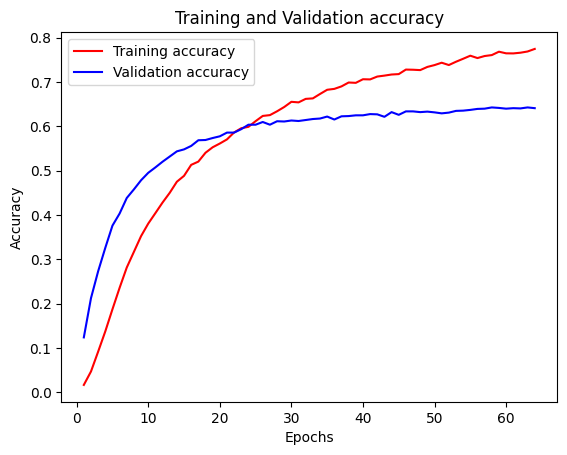

In [22]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=64, train_acc=acc_train, val_acc=acc_val)

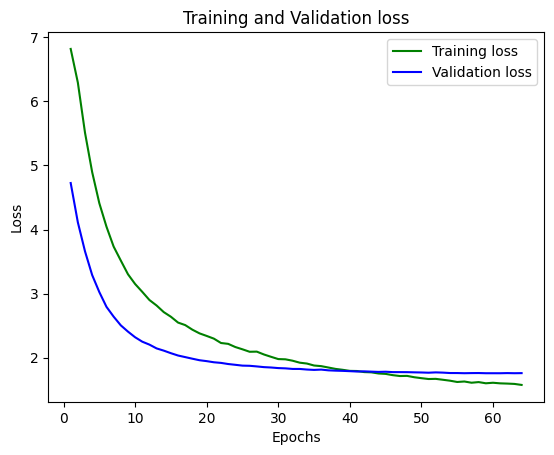

In [24]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plot_model_loss(num_epochs=64, train_loss=loss_train, val_loss=loss_val)

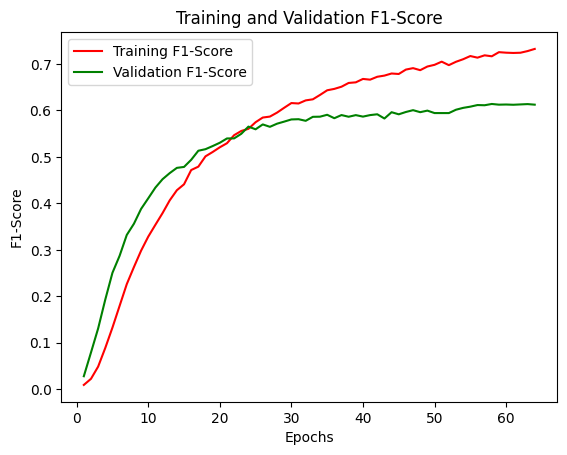

In [25]:
x_axis = range(1,64+1)
plt.plot(x_axis, history.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

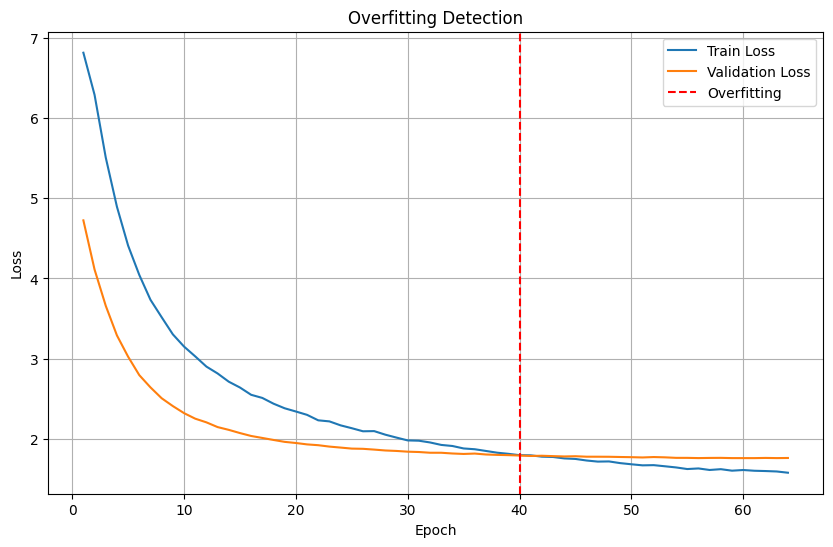

In [30]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

### Train until overfit

In [18]:
input_img = Input(shape=(224, 224, 3))
base_model_cont = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model_cont.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model_cont.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model_cont = models.Model(inputs=base_model_cont.input, outputs=x)

model_cont.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=metrics
)


In [19]:
experiment = Experiment(
    model=model_cont,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_running_to_32_epochs",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,           # Reduce LR if no improvement after 2 epochs
        min_lr=1e-6,
        verbose=1
    )]
    
# Run the experiment
history_cont = experiment.run_experiment(callbacks=callbacks_additional, epochs=32) # callbacks=None use default callbacks (created in the Experiment class)

No checkpoint found, starting from scratch.
Epoch 1/32


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-04-13 15:23:06.106281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.0081 - auc: 0.5220 - f1_score: 0.0039 - loss: 6.9464

2025-04-13 15:25:43.990549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(49, 224, 224, 3))
  warnings.warn(msg)


263/263 ━━━━━━━━━━━━━━━━━━━━ 137s 504ms/step


2025-04-13 15:28:01.682199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.0081 - auc: 0.5220 - f1_score: 0.0039 - loss: 6.9464 - val_accuracy: 0.1202 - val_auc: 0.7144 - val_f1_score: 0.0221 - val_loss: 4.8183 - learning_rate: 1.0000e-04
Epoch 2/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.0362 - auc: 0.5616 - f1_score: 0.0154 - loss: 6.5903

2025-04-13 15:31:00.203547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 145s 547ms/step


2025-04-13 15:33:25.415487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.0362 - auc: 0.5616 - f1_score: 0.0154 - loss: 6.5897 - val_accuracy: 0.1920 - val_auc: 0.7986 - val_f1_score: 0.0628 - val_loss: 4.2138 - learning_rate: 1.0000e-04
Epoch 3/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.0852 - auc: 0.5985 - f1_score: 0.0432 - loss: 5.7945

2025-04-13 15:36:31.958721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 469ms/step


2025-04-13 15:38:36.423762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.0853 - auc: 0.5985 - f1_score: 0.0432 - loss: 5.7941 - val_accuracy: 0.2404 - val_auc: 0.8528 - val_f1_score: 0.1113 - val_loss: 3.7687 - learning_rate: 1.0000e-04
Epoch 4/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.1247 - auc: 0.6287 - f1_score: 0.0707 - loss: 5.1364

2025-04-13 15:41:26.724203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 448ms/step


2025-04-13 15:43:25.568910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.1247 - auc: 0.6287 - f1_score: 0.0707 - loss: 5.1361 - val_accuracy: 0.2994 - val_auc: 0.8902 - val_f1_score: 0.1717 - val_loss: 3.3965 - learning_rate: 1.0000e-04
Epoch 5/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.1671 - auc: 0.6604 - f1_score: 0.1027 - loss: 4.5936

2025-04-13 15:46:24.250557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 457ms/step


2025-04-13 15:48:25.212689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 325ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.1671 - auc: 0.6604 - f1_score: 0.1027 - loss: 4.5934 - val_accuracy: 0.3511 - val_auc: 0.9131 - val_f1_score: 0.2384 - val_loss: 3.1086 - learning_rate: 1.0000e-04
Epoch 6/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.2078 - auc: 0.6797 - f1_score: 0.1420 - loss: 4.1985

2025-04-13 15:51:07.474299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 114s 434ms/step


2025-04-13 15:53:02.272089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.2079 - auc: 0.6797 - f1_score: 0.1421 - loss: 4.1983 - val_accuracy: 0.3901 - val_auc: 0.9288 - val_f1_score: 0.2778 - val_loss: 2.8925 - learning_rate: 1.0000e-04
Epoch 7/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.2597 - auc: 0.6956 - f1_score: 0.1878 - loss: 3.8473

2025-04-13 15:55:53.925972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 113s 427ms/step


2025-04-13 15:57:47.037704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.2598 - auc: 0.6956 - f1_score: 0.1879 - loss: 3.8472 - val_accuracy: 0.4201 - val_auc: 0.9356 - val_f1_score: 0.3222 - val_loss: 2.7207 - learning_rate: 1.0000e-04
Epoch 8/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.2958 - auc: 0.7085 - f1_score: 0.2295 - loss: 3.5938

2025-04-13 16:00:30.710176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 114s 430ms/step


2025-04-13 16:02:24.660250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.2959 - auc: 0.7085 - f1_score: 0.2296 - loss: 3.5937 - val_accuracy: 0.4502 - val_auc: 0.9402 - val_f1_score: 0.3596 - val_loss: 2.5860 - learning_rate: 1.0000e-04
Epoch 9/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.3378 - auc: 0.7184 - f1_score: 0.2629 - loss: 3.3910

2025-04-13 16:05:13.248984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 471ms/step


2025-04-13 16:07:17.912067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.3378 - auc: 0.7184 - f1_score: 0.2630 - loss: 3.3909 - val_accuracy: 0.4686 - val_auc: 0.9456 - val_f1_score: 0.3844 - val_loss: 2.4749 - learning_rate: 1.0000e-04
Epoch 10/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.3668 - auc: 0.7263 - f1_score: 0.2922 - loss: 3.2140

2025-04-13 16:10:05.576668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 113s 427ms/step


2025-04-13 16:11:58.583610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.3668 - auc: 0.7263 - f1_score: 0.2923 - loss: 3.2139 - val_accuracy: 0.4836 - val_auc: 0.9488 - val_f1_score: 0.4048 - val_loss: 2.3876 - learning_rate: 1.0000e-04
Epoch 11/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4086 - auc: 0.7300 - f1_score: 0.3320 - loss: 3.0651

2025-04-13 16:14:35.358533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 444ms/step


2025-04-13 16:16:33.110901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 326ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.4086 - auc: 0.7300 - f1_score: 0.3321 - loss: 3.0651 - val_accuracy: 0.5058 - val_auc: 0.9513 - val_f1_score: 0.4356 - val_loss: 2.3176 - learning_rate: 1.0000e-04
Epoch 12/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.4138 - auc: 0.7345 - f1_score: 0.3430 - loss: 2.9684

2025-04-13 16:19:21.133252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 112s 425ms/step


2025-04-13 16:21:13.752454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.4139 - auc: 0.7345 - f1_score: 0.3431 - loss: 2.9682 - val_accuracy: 0.5153 - val_auc: 0.9535 - val_f1_score: 0.4503 - val_loss: 2.2595 - learning_rate: 1.0000e-04
Epoch 13/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4417 - auc: 0.7402 - f1_score: 0.3699 - loss: 2.8406

2025-04-13 16:23:53.328172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 112s 422ms/step


2025-04-13 16:25:45.176363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.4417 - auc: 0.7402 - f1_score: 0.3700 - loss: 2.8406 - val_accuracy: 0.5242 - val_auc: 0.9531 - val_f1_score: 0.4600 - val_loss: 2.2110 - learning_rate: 1.0000e-04
Epoch 14/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.4600 - auc: 0.7442 - f1_score: 0.3910 - loss: 2.7550

2025-04-13 16:28:45.595207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 132s 502ms/step


2025-04-13 16:30:58.594656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 443ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.4600 - auc: 0.7442 - f1_score: 0.3912 - loss: 2.7549 - val_accuracy: 0.5337 - val_auc: 0.9551 - val_f1_score: 0.4722 - val_loss: 2.1717 - learning_rate: 1.0000e-04
Epoch 15/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.4723 - auc: 0.7463 - f1_score: 0.3993 - loss: 2.6858

2025-04-13 16:34:09.206151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 446ms/step


2025-04-13 16:36:07.343022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.4723 - auc: 0.7463 - f1_score: 0.3994 - loss: 2.6858 - val_accuracy: 0.5420 - val_auc: 0.9562 - val_f1_score: 0.4843 - val_loss: 2.1296 - learning_rate: 1.0000e-04
Epoch 16/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.4969 - auc: 0.7502 - f1_score: 0.4257 - loss: 2.5751

2025-04-13 16:39:06.297802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 449ms/step


2025-04-13 16:41:05.316179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.4969 - auc: 0.7502 - f1_score: 0.4258 - loss: 2.5751 - val_accuracy: 0.5459 - val_auc: 0.9590 - val_f1_score: 0.4890 - val_loss: 2.0984 - learning_rate: 1.0000e-04
Epoch 17/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4947 - auc: 0.7540 - f1_score: 0.4260 - loss: 2.5438

2025-04-13 16:59:07.619594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1434s 5s/step


2025-04-13 17:23:01.753380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 920s 16s/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 3418s 13s/step - accuracy: 0.4948 - auc: 0.7540 - f1_score: 0.4262 - loss: 2.5437 - val_accuracy: 0.5570 - val_auc: 0.9591 - val_f1_score: 0.5028 - val_loss: 2.0618 - learning_rate: 1.0000e-04
Epoch 18/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.5296 - auc: 0.7541 - f1_score: 0.4565 - loss: 2.4685

2025-04-13 17:41:00.005249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 114s 430ms/step


2025-04-13 17:42:54.303146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.5297 - auc: 0.7541 - f1_score: 0.4566 - loss: 2.4684 - val_accuracy: 0.5648 - val_auc: 0.9602 - val_f1_score: 0.5172 - val_loss: 2.0413 - learning_rate: 1.0000e-04
Epoch 19/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.5387 - auc: 0.7568 - f1_score: 0.4647 - loss: 2.4192

2025-04-13 17:45:44.557982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 451ms/step


2025-04-13 17:47:43.865354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.5387 - auc: 0.7568 - f1_score: 0.4648 - loss: 2.4191 - val_accuracy: 0.5632 - val_auc: 0.9600 - val_f1_score: 0.5159 - val_loss: 2.0283 - learning_rate: 1.0000e-04
Epoch 20/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.5580 - auc: 0.7568 - f1_score: 0.4870 - loss: 2.3399

2025-04-13 17:51:49.822746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 1026s 4s/step


2025-04-13 18:08:56.288179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1275s 5s/step - accuracy: 0.5580 - auc: 0.7568 - f1_score: 0.4871 - loss: 2.3399 - val_accuracy: 0.5737 - val_auc: 0.9591 - val_f1_score: 0.5253 - val_loss: 2.0003 - learning_rate: 1.0000e-04
Epoch 21/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5552 - auc: 0.7588 - f1_score: 0.4853 - loss: 2.3199

2025-04-13 18:11:50.000423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 451ms/step


2025-04-13 18:13:49.675365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 325ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.5552 - auc: 0.7587 - f1_score: 0.4854 - loss: 2.3199 - val_accuracy: 0.5787 - val_auc: 0.9604 - val_f1_score: 0.5332 - val_loss: 1.9840 - learning_rate: 1.0000e-04
Epoch 22/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5761 - auc: 0.7596 - f1_score: 0.4999 - loss: 2.2693

2025-04-13 18:16:39.036584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 455ms/step


2025-04-13 18:18:39.700019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.5761 - auc: 0.7596 - f1_score: 0.5001 - loss: 2.2693 - val_accuracy: 0.5793 - val_auc: 0.9611 - val_f1_score: 0.5334 - val_loss: 1.9746 - learning_rate: 1.0000e-04
Epoch 23/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5856 - auc: 0.7605 - f1_score: 0.5126 - loss: 2.2416

2025-04-13 18:23:53.454682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 115s 437ms/step


2025-04-13 18:25:49.222300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.5856 - auc: 0.7605 - f1_score: 0.5127 - loss: 2.2416 - val_accuracy: 0.5765 - val_auc: 0.9608 - val_f1_score: 0.5326 - val_loss: 1.9577 - learning_rate: 1.0000e-04
Epoch 24/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5882 - auc: 0.7625 - f1_score: 0.5155 - loss: 2.2021

2025-04-13 18:28:38.823750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 116s 440ms/step


2025-04-13 18:30:35.267602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.5883 - auc: 0.7625 - f1_score: 0.5156 - loss: 2.2020 - val_accuracy: 0.5815 - val_auc: 0.9611 - val_f1_score: 0.5378 - val_loss: 1.9477 - learning_rate: 1.0000e-04
Epoch 25/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.6080 - auc: 0.7629 - f1_score: 0.5352 - loss: 2.1584

2025-04-13 18:33:33.253171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 449ms/step


2025-04-13 18:35:32.148136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 329ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.6080 - auc: 0.7629 - f1_score: 0.5353 - loss: 2.1583 - val_accuracy: 0.5882 - val_auc: 0.9615 - val_f1_score: 0.5435 - val_loss: 1.9314 - learning_rate: 1.0000e-04
Epoch 26/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.6147 - auc: 0.7631 - f1_score: 0.5402 - loss: 2.1391

2025-04-13 18:38:24.791066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 445ms/step


2025-04-13 18:40:22.434358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.6147 - auc: 0.7631 - f1_score: 0.5403 - loss: 2.1391 - val_accuracy: 0.5876 - val_auc: 0.9620 - val_f1_score: 0.5435 - val_loss: 1.9270 - learning_rate: 1.0000e-04
Epoch 27/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.6189 - auc: 0.7641 - f1_score: 0.5432 - loss: 2.1064

2025-04-13 18:43:17.414107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 116s 440ms/step


2025-04-13 18:45:13.961395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.6189 - auc: 0.7641 - f1_score: 0.5433 - loss: 2.1063 - val_accuracy: 0.5954 - val_auc: 0.9630 - val_f1_score: 0.5513 - val_loss: 1.9086 - learning_rate: 1.0000e-04
Epoch 28/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.6258 - auc: 0.7649 - f1_score: 0.5510 - loss: 2.0786

2025-04-13 18:48:13.298990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 443ms/step


2025-04-13 18:50:10.495985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 323ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.6258 - auc: 0.7649 - f1_score: 0.5511 - loss: 2.0786 - val_accuracy: 0.5938 - val_auc: 0.9619 - val_f1_score: 0.5522 - val_loss: 1.9032 - learning_rate: 1.0000e-04
Epoch 29/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.6405 - auc: 0.7667 - f1_score: 0.5622 - loss: 2.0358

2025-04-13 18:53:03.932448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 452ms/step


2025-04-13 18:55:03.673929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.6405 - auc: 0.7667 - f1_score: 0.5624 - loss: 2.0358 - val_accuracy: 0.5993 - val_auc: 0.9625 - val_f1_score: 0.5599 - val_loss: 1.8935 - learning_rate: 1.0000e-04
Epoch 30/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.6498 - auc: 0.7680 - f1_score: 0.5750 - loss: 2.0191

2025-04-13 18:58:14.749279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 451ms/step


2025-04-13 19:00:14.009029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 338ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.6498 - auc: 0.7680 - f1_score: 0.5751 - loss: 2.0191 - val_accuracy: 0.6032 - val_auc: 0.9631 - val_f1_score: 0.5634 - val_loss: 1.8885 - learning_rate: 1.0000e-04
Epoch 31/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.6465 - auc: 0.7700 - f1_score: 0.5716 - loss: 2.0006

2025-04-13 19:03:14.383986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 453ms/step


2025-04-13 19:05:14.242297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.6466 - auc: 0.7700 - f1_score: 0.5717 - loss: 2.0006 - val_accuracy: 0.5999 - val_auc: 0.9638 - val_f1_score: 0.5619 - val_loss: 1.8772 - learning_rate: 1.0000e-04
Epoch 32/32
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.6513 - auc: 0.7705 - f1_score: 0.5734 - loss: 1.9701

2025-04-13 19:08:10.172396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 453ms/step


2025-04-13 19:10:10.067923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.6513 - auc: 0.7705 - f1_score: 0.5736 - loss: 1.9700 - val_accuracy: 0.5988 - val_auc: 0.9630 - val_f1_score: 0.5603 - val_loss: 1.8710 - learning_rate: 1.0000e-04


In [19]:
experiment.model.save("resnet50_with_preprocessing_running_to_32_epochs.keras")

NameError: name 'experiment' is not defined

In [18]:
pd.DataFrame(history_cont.history).to_csv("resnet50_with_preprocessing_running_to_32_epochs.csv", index=False)

NameError: name 'history_cont' is not defined

### Fine-tune

In [13]:
model_ft = load_model("resnet50_with_preprocessing_running_to_32_epochs.keras", compile=False)

In [24]:
trainable = False
for layer in model_ft.layers:
    if "conv5_block1_1_conv" in layer.name:
        trainable = True
    layer.trainable = trainable

model_ft.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

In [27]:
experiment = Experiment(
    model=model_ft,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_finetuning_phase_v2",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_finetune = [
    ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True, verbose=1)
]
    
# Run the experiment
history_finetune = model_ft.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # ou até 15 no máximo
    callbacks=callbacks_finetune
)

Epoch 1/10


2025-04-14 10:16:55.870900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


263/263 ━━━━━━━━━━━━━━━━━━━━ 241s 884ms/step - accuracy: 0.5315 - auc: 0.7484 - f1_score: 0.4691 - loss: 2.6221 - val_accuracy: 0.6055 - val_auc: 0.9643 - val_f1_score: 0.5687 - val_loss: 1.8210 - learning_rate: 1.0000e-05
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 204s 767ms/step - accuracy: 0.5971 - auc: 0.7568 - f1_score: 0.5305 - loss: 2.2911 - val_accuracy: 0.6188 - val_auc: 0.9647 - val_f1_score: 0.5800 - val_loss: 1.7869 - learning_rate: 1.0000e-05
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 194s 739ms/step - accuracy: 0.6319 - auc: 0.7610 - f1_score: 0.5574 - loss: 2.1379 - val_accuracy: 0.6210 - val_auc: 0.9646 - val_f1_score: 0.5816 - val_loss: 1.7488 - learning_rate: 1.0000e-05
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 195s 740ms/step - accuracy: 0.6825 - auc: 0.7646 - f1_score: 0.6036 - loss: 1.9791 - val_accuracy: 0.6277 - val_auc: 0.9644 - val_f1_score: 0.5920 - val_loss: 1.7173 - learning_rate: 1.0000e-05
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 200s 760ms/step - accuracy: 0.7034 

In [14]:
test_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/test",
    minority_class=minority_class,
    augment=None,
    preprocessing_function=preprocess_input
)

Found 1798 files belonging to 202 classes.


In [22]:
model_ft = load_model("resnet50_with_preprocessing_running_to_32_epochs.keras", compile=False)
model_ft.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Get true labels
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_true = np.argmax(y_true, axis=1)

# Get predicted probabilities
y_pred_probs = model_ft.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Métricas principais
print(classification_report(y_true, y_pred, digits=3))
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))


2025-04-14 11:37:29.719630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step
              precision    recall  f1-score   support

           0      0.667     0.667     0.667        18
           1      0.400     0.429     0.414        14
           2      0.549     0.875     0.675        32
           3      0.333     0.111     0.167         9
           4      0.407     0.611     0.489        18
           5      1.000     0.250     0.400         4
           6      1.000     0.200     0.333         5
           7      0.333     0.250     0.286         4
           8      0.500     0.111     0.182         9
           9      0.500     0.333     0.400         9
          10      0.630     0.630     0.630        27
          11      0.800     0.444     0.571         9
          12      0.833     0.556     0.667         9
          13      0.913     0.913     0.913        23
          14      0.857     0.667     0.750         9
          15      0.000     0.000     0.000         5
          16      0.522     0.522     0

/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.7396..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-109.54765..145.23947].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-100.94433..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..144.4896].
Clipping 

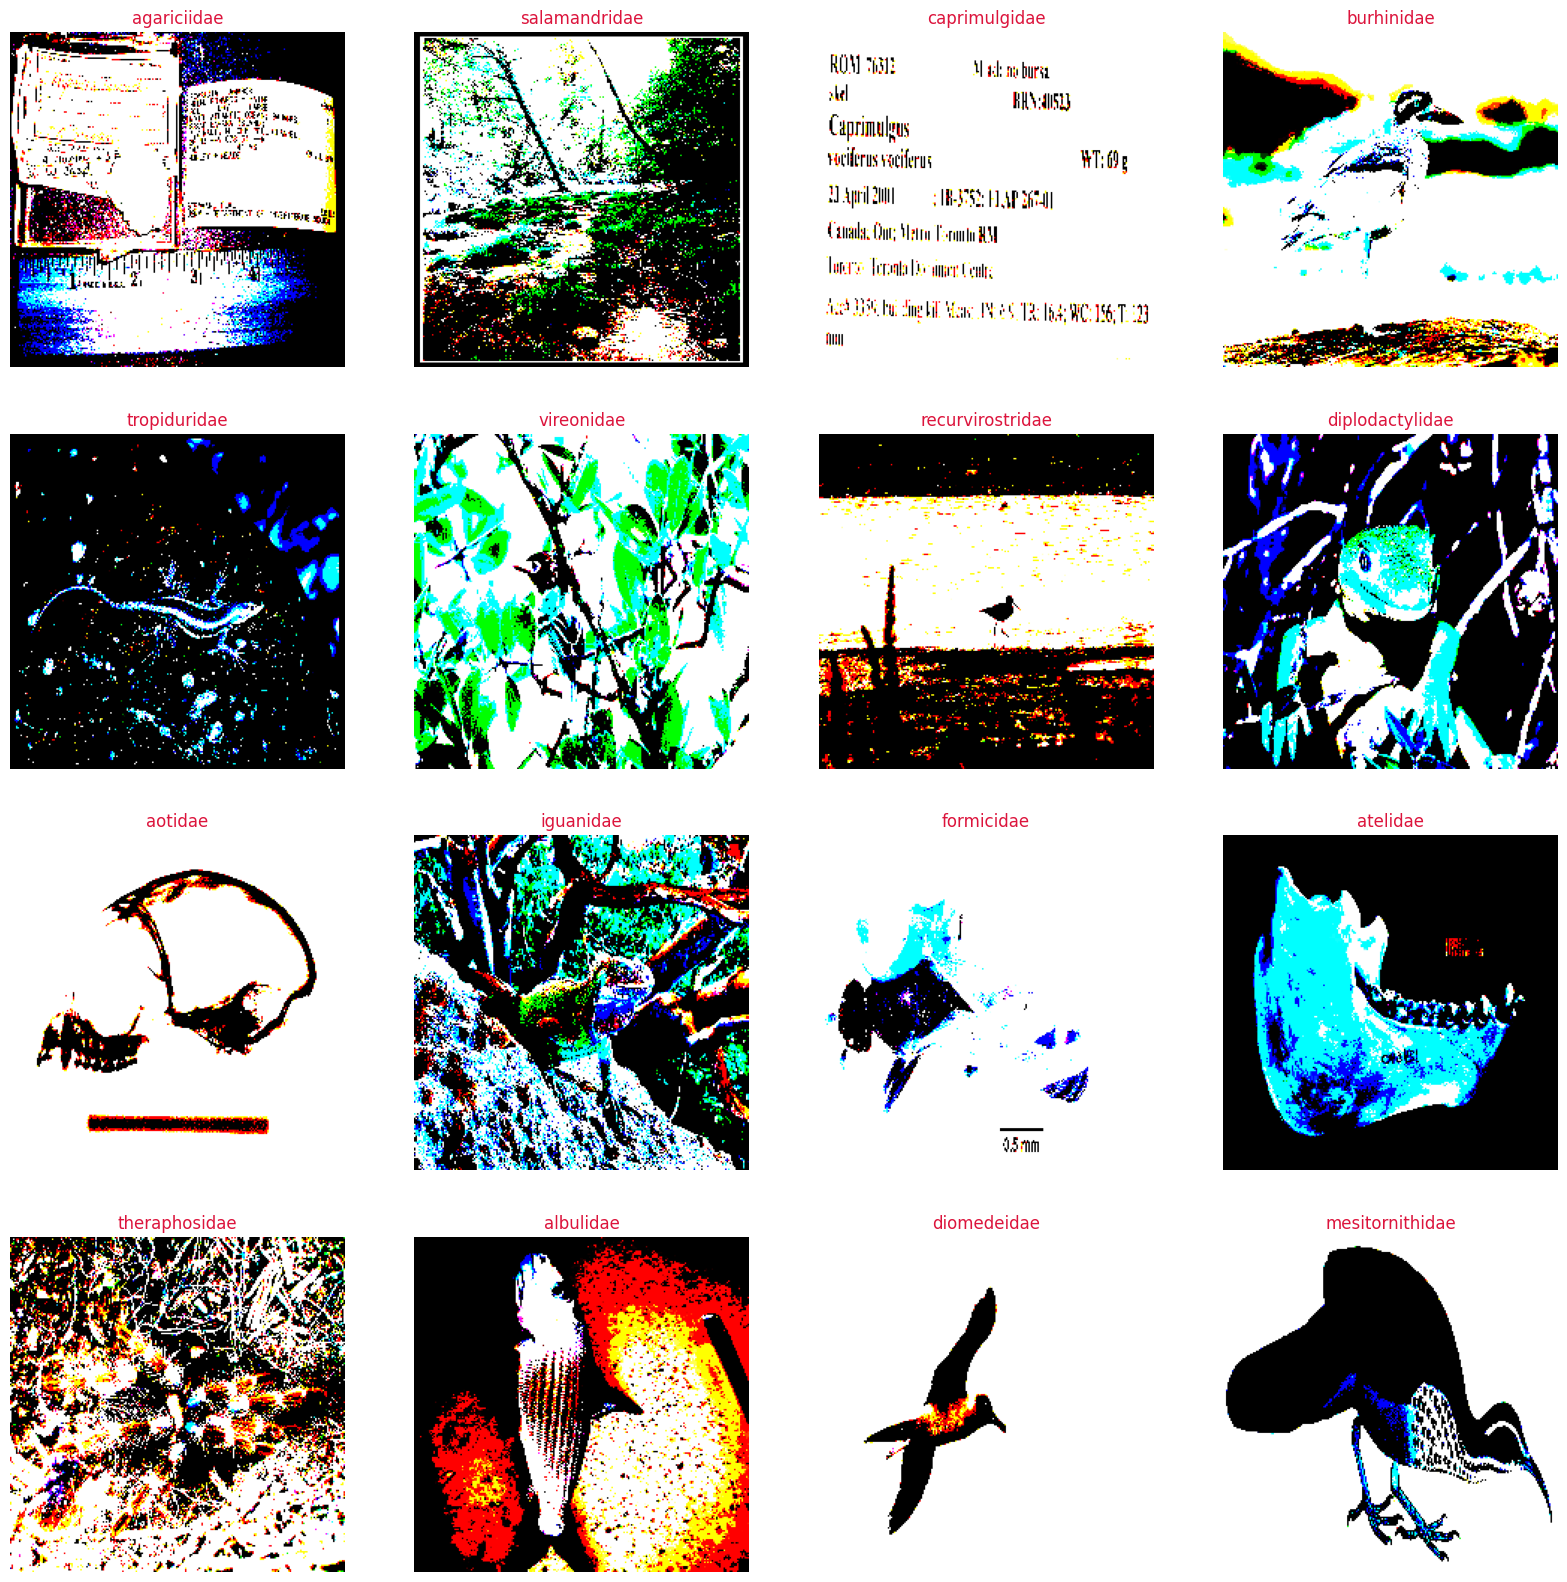

In [ ]:
num_images = 16 ##
rows, cols = 4, 4 ##



In [26]:

history = model.fit(train_ds, epochs=50, batch_size=32, validation_data=val_ds, callbacks=callbacks)

NameError: name 'callbacks' is not defined

In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

## EfficientNet

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

#initial_lr = 1e-4  
#final_lr = 1e-5
n_epochs = 50
#my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
#   lr_scheduler=my_scheduler_fn
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Número de classes (families) — substitui com o teu número real
num_classes = len(df['family'].unique())

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

# congela só as primeiras camadas
for layer in base_model.layers[:150]:
    layer.trainable = False

# Topo personalizado
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(202, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

# Compilar
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("checkpoints/model.keras", monitor='val_loss', save_best_only=True),
    CSVLogger("logs/run2.csv")
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 165s 565ms/step - acc: 0.0135 - auc: 0.5654 - f1_score: 0.0047 - loss: 7.3565 - val_acc: 0.0173 - val_auc: 0.6483 - val_f1_score: 1.6791e-04 - val_loss: 5.1712
Epoch 2/30
 86/263 ━━━━━━━━━━━━━━━━━━━━ 1:28 502ms/step - acc: 0.0171 - auc: 0.5969 - f1_score: 0.0028 - loss: 5.9324

KeyboardInterrupt: 